# Spam Email detection: Feature Engineering
Prepared By Deepa Francis<br>
For BrainStation<br>
On July 31, 2023

# Table of Contents<br>

[1. Features](#ft) <br>
[2. Feature 1: email_to](#et) <br>
- [2.1. xxx](#et1) <br>

[3. Feature 2: email_from](#ef) <br>
- [3.1. Feature hashing](#ef1) <br>
- [3.2. One Hot Encode](#ef1) <br>

[4. Numerical Features](#nf) <br>
[5. Train Test Split](#tts) <br>
[6. Feature 3: subject](#sub) <br>
[7. Feature 4: message](#msg) <br>

In [227]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings('ignore')

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

# display all columns in dataframe
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [220]:
# Functions used in the notebook

#1# Create function for concatenating two dataframes and dropping specific columns from them
def concat_and_drop(df1, df2, columns_to_drop):
    df1.reset_index(drop=True, inplace=True)
    df1 = pd.concat([df1, df2], axis=1)
    df1 = df1.drop(columns=columns_to_drop)
    return df1 

#2# Create function for converting feature hashed sparse matrix to dataframe
def feature_hashed_df(hashed_sparse_matrix):
    # Get the actual number of unique hash values (n_features)
    label_n_features = hashed_sparse_matrix.shape[1]

    # Get the names of the columns resulting from the FeatureHasher
    hashed_columns = [f"hash_{i}" for i in range(label_n_features)]

    # Create a DataFrame using the dense array representation and the concatenated column names
    feature_hashed_df = pd.DataFrame(hashed_sparse_matrix.toarray(), columns=hashed_columns)

    # Add the 'from_' prefix to the DataFrame columns to match the original column names
    feature_hashed_df = feature_hashed_df.add_prefix('email_from_')

    # Reset the DataFrame index
    feature_hashed_df.reset_index(drop=True, inplace=True)

    # View the resulting DataFrame
    return feature_hashed_df

In [174]:
# Load the sampled data
sampled_data = pd.read_csv('sampled_data.csv') 

In [175]:
# Instantiate sample features and target
X_sample = sampled_data.drop(columns="label")
y_sample = sampled_data["label"]

In [176]:
# Check the shapes of feature and target
print('The shape of Features: ', X_sample.shape)
print('The shape of Target: ', y_sample.shape)

The shape of Features:  (40000, 4)
The shape of Target:  (40000,)


In [177]:
# Check the features
X_sample.head()

,subject,email_to,email_from,message
0,Re: [sugar] new Sugar dependency: libtelepathy...,sugar@laptop.org,Dafydd Harries <daf@rhydd.org>,Content-Type: text/plain; charset=us-ascii\nCo...
1,Rev 307: enable TCP keepalives in http://samba...,samba-cvs@samba.org,tridge@samba.org,----------------------------------------------...
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,"""OtherRecipients of perl Ticket #43105"": ;","""Bernhard Schmalhofer via RT"" <parrotbug-follo...",> > What happens when NULL is not a consective...
3,Re: [R] Appropriate regression model for categ...,R-help@stat.math.ethz.ch,Robert A LaBudde <ral@lcfltd.com>,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us..."
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,ktwarwic@flax9.UWATERLOO.CA,Showbiz Tonight <showbiz@mail.cnn.com>,"Content-type: text/plain; charset=""US-ASCII"" T..."


There are four features. All of them are text data. Lets take look into them one by one

<a id = "et"></a>
## 2. Feature 1: email_to

Since the goal of the machine learning task is spam detection, the recipient email address might not provide relevant information for the specific task. Dropping the "email_to" feature allows the model to focus solely on the nature of incoming emails.<br>

If the dataset contains a large number of unique email addresses in the "email_to" feature, including it as a categorical feature could lead to high dimensionality. High-dimensional feature spaces can pose challenges in terms of computational complexity, memory usage, and model interpretability. <br>

By dropping the "email_to" feature, the dimensionality of the feature space is reduced, simplifying the machine learning process.

In [178]:
# Drop the 'email_to' column
X_sample.drop('email_to', axis=1, inplace=True)
# Confirm the changes
X_sample.head()

,subject,email_from,message
0,Re: [sugar] new Sugar dependency: libtelepathy...,Dafydd Harries <daf@rhydd.org>,Content-Type: text/plain; charset=us-ascii\nCo...
1,Rev 307: enable TCP keepalives in http://samba...,tridge@samba.org,----------------------------------------------...
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,"""Bernhard Schmalhofer via RT"" <parrotbug-follo...",> > What happens when NULL is not a consective...
3,Re: [R] Appropriate regression model for categ...,Robert A LaBudde <ral@lcfltd.com>,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us..."
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,Showbiz Tonight <showbiz@mail.cnn.com>,"Content-type: text/plain; charset=""US-ASCII"" T..."


<a id = "ef"></a>
## 3. Feature 2: email_from

email_from feature has the email address of the sender. It has a pattern. So we can extract displayname, username, email host and domain extension from this.

In [179]:
# Check unique values of email_from
X_sample['email_from'].value_counts().count()

22619

We are using pandas string method called extract. It is used to extract substrings from the "email_from" column that match the specified regular expression pattern.

In [180]:
# clean email_from
df_email_from = pd.DataFrame()
df_email_from["from_display_name"] = X_sample["email_from"].str.extract(r"^([^<]+)")
df_email_from["from_username"] = X_sample["email_from"].str.extract(r"<(.*?)@")
df_email_from["from_host"] = X_sample["email_from"].str.extract(r"@(\w+)")
df_email_from["from_domain"] = X_sample["email_from"].str.extract(r"@[\w.]+\.(\w+)")

# Removing double quotes (") and commas (,) from "display_name" column
df_email_from["from_display_name"] = df_email_from["from_display_name"].str.replace(r'[",]', '')

# View the extracted results
df_email_from.head()

,from_display_name,from_username,from_host,from_domain
0,Dafydd Harries,daf,rhydd,org
1,tridge@samba.org,NaN,samba,org
2,"""Bernhard Schmalhofer via RT""",parrotbug-followup,parrotcode,org
3,Robert A LaBudde,ral,lcfltd,com
4,Showbiz Tonight,showbiz,mail,com


Now we need to clean this dataframe before making it into features

In [181]:
# Number of missing values in the email_from dataframe
print(f"Number of missing values: {df_email_from.isna().sum().sum()}")

Number of missing values: 5336


In [182]:
# Check column wise count of missing values
df_email_from.isna().sum()

from_display_name     753
from_username        2938
from_host               4
from_domain          1641
dtype: int64

Replace null values and missing values with 'Unkown' string, since we don't have this information available.

In [183]:
df_email_from['from_display_name'] = df_email_from['from_display_name'].replace([np.nan, ''], 'Unknown')
df_email_from['from_username'] = df_email_from['from_username'].replace([np.nan, ''], 'Unknown')
df_email_from['from_host'] = df_email_from['from_host'].replace([np.nan, ''], 'Unknown')
df_email_from['from_domain'] = df_email_from['from_domain'].replace([np.nan, ''], 'Unknown')

# Check column wise count of missing values
df_email_from.isna().sum()

from_display_name    0
from_username        0
from_host            0
from_domain          0
dtype: int64

Lets closely examine each of the extracted features.

**Email Host: from_host**

In [184]:
# Unique email hosts
print('There are', df_email_from['from_host'].value_counts().count(), ' email hosts')

There are 13158  email hosts


Lets see which are the top 20 email hosts

from_host
samba         2851
gmail         2692
yahoo         1028
mail           939
broadcast      637
cbsig          549
messaging      336
stats          335
hotmail        320
parrotcode     312
foxnews        223
pelmorex       205
debian         197
gmx            183
flax9          169
ebs            168
verizon        161
keionline      156
calcium        152
wgz            150
Name: count, dtype: int64


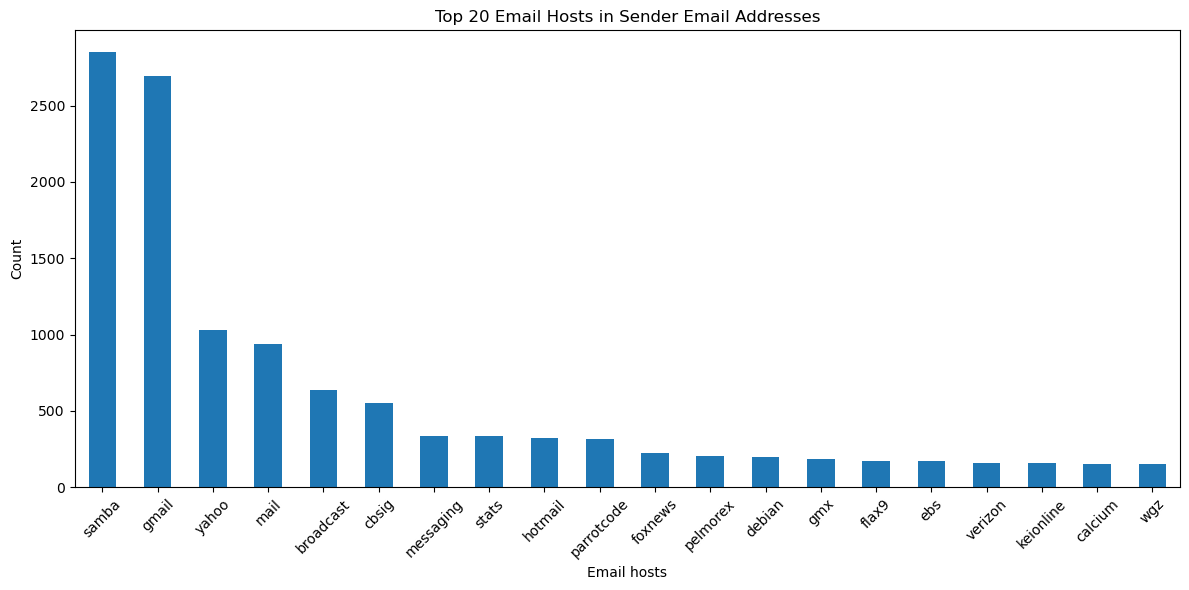

In [185]:
top_20_counts = df_email_from['from_host'].value_counts().head(20)
print(top_20_counts)

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
top_20_counts.plot(kind='bar')
plt.xlabel('Email hosts')
plt.ylabel('Count')
plt.title('Top 20 Email Hosts in Sender Email Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the top 20 email hosts, lets keep the popular ones and club the rest of them together as 'Others'.

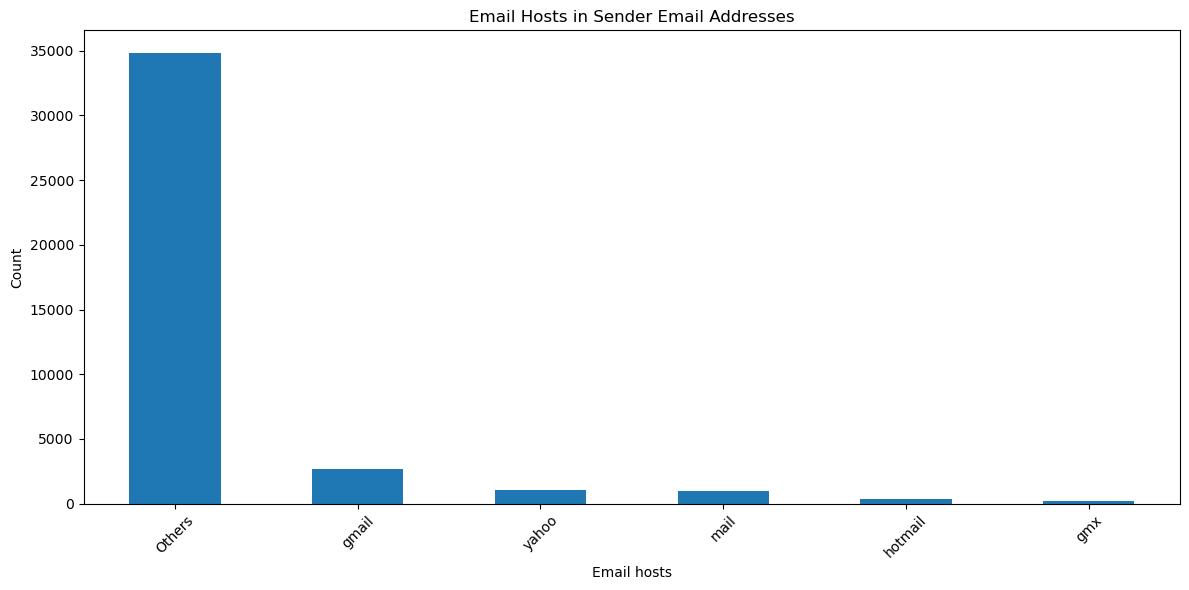

In [186]:
# List of email hosts to keep
popular_email_hosts = ['gmail', 'yahoo', 'mail', 'hotmail', 'gmx']

# Map the 'from_host' column to 'Others' using lambda function and .apply
df_email_from['from_host'] = df_email_from['from_host'].apply(lambda host: host if host in popular_email_hosts else 'Others')

# Display new value counts for Sender email host
email_host_counts = df_email_from['from_host'].value_counts()

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
email_host_counts.plot(kind='bar')
plt.xlabel('Email hosts')
plt.ylabel('Count')
plt.title('Email Hosts in Sender Email Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

View the top email host categories removing 'Others'

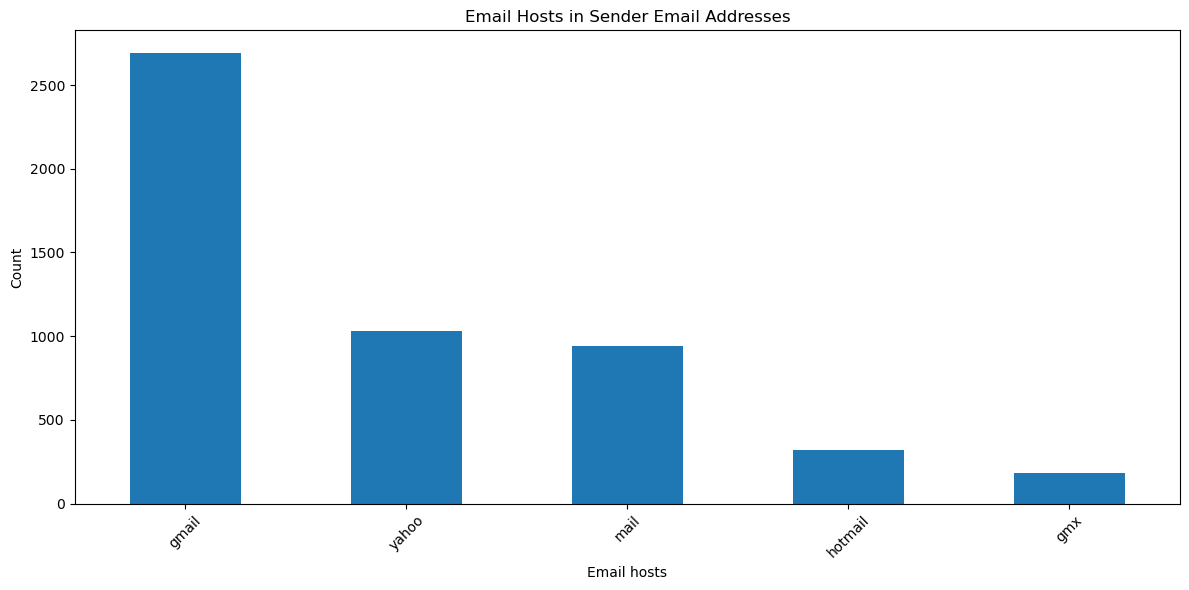

In [187]:
# Filter out the 'Others' category from the value counts
top_email_hosts = email_host_counts.drop('Others')

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
top_email_hosts[:20].plot(kind='bar')
plt.xlabel('Email hosts')
plt.ylabel('Count')
plt.title('Email Hosts in Sender Email Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [188]:
# Check the new feature classes
df_email_from.sample(5)

,from_display_name,from_username,from_host,from_domain
4163,Dan Williams,dcbw,Others,com
5600,David Collier-Brown,davec-b,Others,com
12182,James E Keenan,jkeen,Others,net
11141,Alexandra HEUMBER,Alexandra.HEUMBER,Others,org
26574,"""Customer Support""",bounce,Others,fm


**Email Host: from_domain**

In [189]:
# Unique email domain
print('There are', df_email_from['from_domain'].value_counts().count(), ' email domain extensions')

There are 191  email domain extensions


Lets see which are the top 20 email domains

from_domain
com        20027
org         5252
net         3521
Unknown     1641
ca          1220
uk          1187
edu          933
de           706
biz          418
au           382
it           318
fr           292
jp           230
br           211
nl           208
dk           178
cz           164
COM          152
ch           145
pl           138
Name: count, dtype: int64


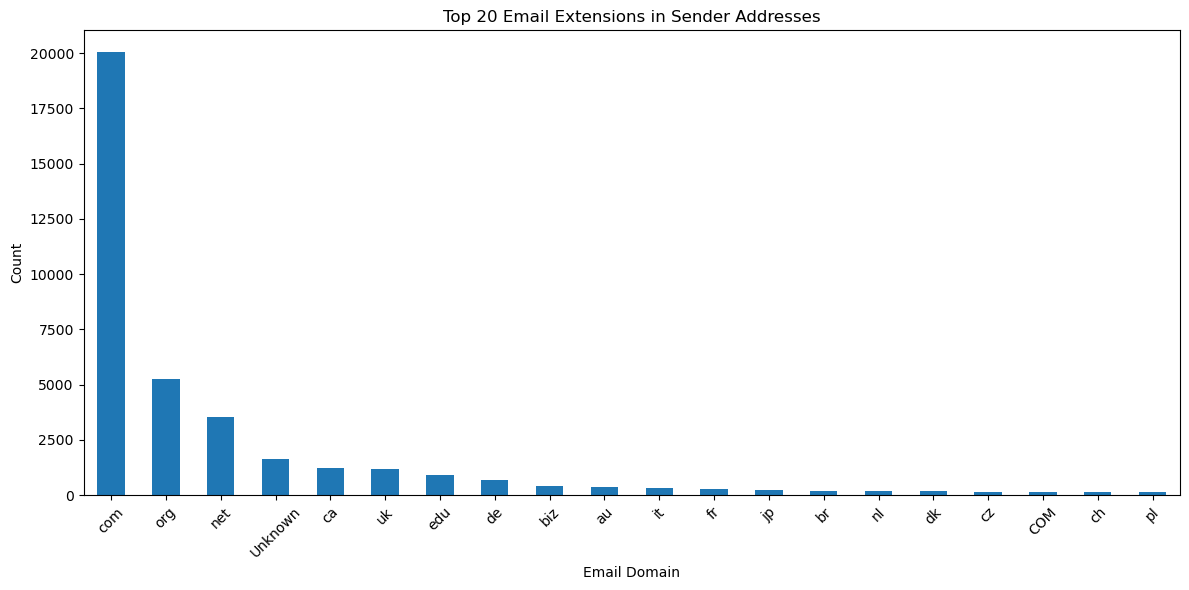

In [190]:
top_20_counts = df_email_from['from_domain'].value_counts().head(20)
print(top_20_counts)

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
top_20_counts.plot(kind='bar')
plt.xlabel('Email Domain')
plt.ylabel('Count')
plt.title('Top 20 Email Extensions in Sender Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the top 20 email domains, lets keep the popular ones and club the rest of them together as 'Others'.

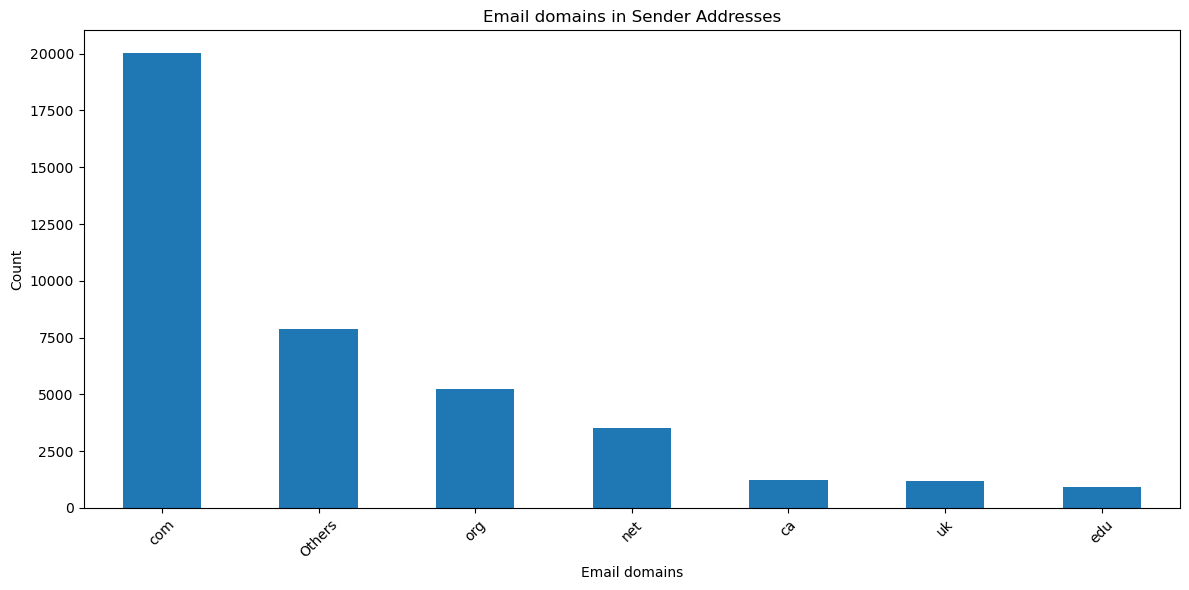

In [191]:
# List of email domains to keep
known_email_domains = ['com', 'org', 'net', 'uk', 'ca', 'edu']

# Map the 'from_domain' column to 'Others' using lambda function and .apply
df_email_from['from_domain'] = df_email_from['from_domain'].apply(lambda domain: domain if domain in known_email_domains else 'Others')

# Display new value counts for Sender email host
email_domain_counts = df_email_from['from_domain'].value_counts()

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
email_domain_counts.plot(kind='bar')
plt.xlabel('Email domains')
plt.ylabel('Count')
plt.title('Email domains in Sender Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [192]:
# Check the new feature classes
df_email_from.sample(5)

,from_display_name,from_username,from_host,from_domain
3087,Common Dreams,commondreams,mail,org
38637,Leonard,ffraid,Others,net
13151,"""Patrick Wang""",pwang,Others,edu
18868,tridge@samba.org,Unknown,Others,org
14718,Unknown,alert,Others,com


Finally, join the extracted features to Feature dataframe and remove the email_from feature.

In [193]:
# Use concat_and_drop function for joining the extracted features
X_sample = concat_and_drop(X_sample, df_email_from, 'email_from')
# Check the changes
X_sample.head()

,subject,message,from_display_name,from_username,from_host,from_domain
0,Re: [sugar] new Sugar dependency: libtelepathy...,Content-Type: text/plain; charset=us-ascii\nCo...,Dafydd Harries,daf,Others,org
1,Rev 307: enable TCP keepalives in http://samba...,----------------------------------------------...,tridge@samba.org,Unknown,Others,org
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,> > What happens when NULL is not a consective...,"""Bernhard Schmalhofer via RT""",parrotbug-followup,Others,org
3,Re: [R] Appropriate regression model for categ...,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us...",Robert A LaBudde,ral,Others,com
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,"Content-type: text/plain; charset=""US-ASCII"" T...",Showbiz Tonight,showbiz,mail,com


<a id = "nf"></a>
## 4. Numerical Features

We are going to extract some numerical features from subject and message features. We can count the number of words in each of these features and add it as an additional feature.
Extremely short or long subjects/messages might contain unique characteristics. The word count feature allows machine learning algorithms to identify and potentially leverage such patterns.

In [194]:
# Add feature: Word count of hotel name
X_sample['subject_Word_Count'] = X_sample['subject'].str.split().str.len()

# Add feature: Word count of hotel name
X_sample['message_Word_Count'] = X_sample['message'].str.split().str.len()

# Check the changes
X_sample.head()

,subject,message,from_display_name,from_username,from_host,from_domain,subject_Word_Count,message_Word_Count
0,Re: [sugar] new Sugar dependency: libtelepathy...,Content-Type: text/plain; charset=us-ascii\nCo...,Dafydd Harries,daf,Others,org,6,165
1,Rev 307: enable TCP keepalives in http://samba...,----------------------------------------------...,tridge@samba.org,Unknown,Others,org,7,95
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,> > What happens when NULL is not a consective...,"""Bernhard Schmalhofer via RT""",parrotbug-followup,Others,org,9,198
3,Re: [R] Appropriate regression model for categ...,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us...",Robert A LaBudde,ral,Others,com,8,209
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,"Content-type: text/plain; charset=""US-ASCII"" T...",Showbiz Tonight,showbiz,mail,com,10,523


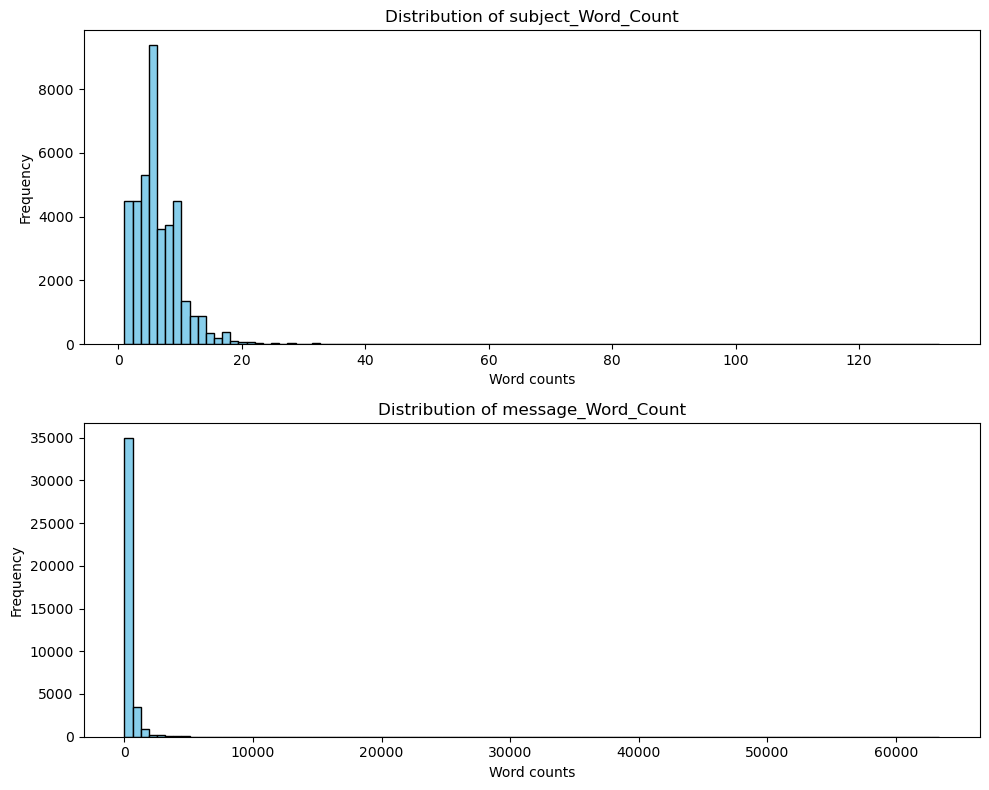

In [195]:
# Checking the distribution of numerical features
column_names = ['subject_Word_Count', 'message_Word_Count']

# Create subplots to plot multiple features in the same figure
num_features = len(column_names)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 4 * num_features))

# Plot histograms for each numerical feature
for i in range(num_features):
    feature_values = X_sample[column_names[i]]
    
    # Plot a histogram for the feature
    axes[i].hist(feature_values, bins=100, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {column_names[i]}')
    axes[i].set_xlabel('Word counts')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

We are going to clip the values for outlier handling. In subject word counts, everything above 20 word counts are set to 20.<br>
In the message word count, we are clipping theshold is set to 434 based on the research which showed that an average email message is 434.48 words. Please refer the source given below <br>
https://blog.aweber.com/learn/average-email-length.htm#:~:text=The%20average%20email%20length,approximately%203.3%20minutes%20to%20read


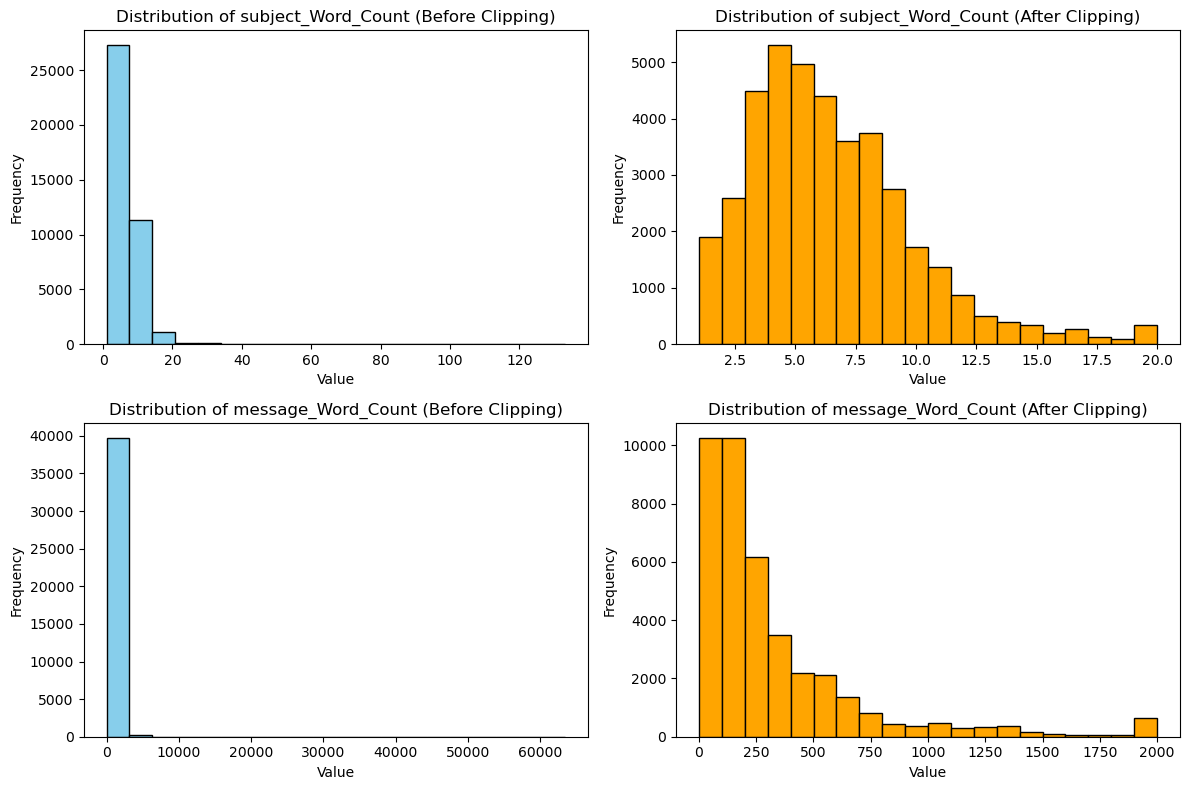

In [196]:
# Clipping outliers
X_sample['subject_Word_Count_clipped'] = X_sample['subject_Word_Count'].clip(upper=20)
X_sample['message_Word_Count_clipped'] = X_sample['message_Word_Count'].clip(upper=2000)

# Column names for reference
column_names1 = ['subject_Word_Count', 'message_Word_Count']
column_names2 = ['subject_Word_Count_clipped', 'message_Word_Count_clipped']

# Create subplots to plot multiple features in the same figure
num_features = len(column_names)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 4 * num_features))

# Plot histograms before and after clipping for each numerical feature
for i in range(num_features):
    # Before clipping
    axes[i, 0].hist(X_sample[column_names1[i]], bins=20, color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'Distribution of {column_names[i]} (Before Clipping)')
    axes[i, 0].set_xlabel('Word count')
    axes[i, 0].set_ylabel('Frequency')

    # After clipping
    clipped_feature = X_sample[column_names2[i]].clip(upper=2000)  # Clip the data again for the "After Clipping" histogram
    axes[i, 1].hist(clipped_feature, bins=20, color='orange', edgecolor='black')
    axes[i, 1].set_title(f'Distribution of {column_names[i]} (After Clipping)')
    axes[i, 1].set_xlabel('Word Count')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [199]:
# Drop the original word count columns
X_sample = X_sample.drop(['subject_Word_Count', 'message_Word_Count'], axis=1)
# Check the changes
X_sample.head()

,subject,message,from_display_name,from_username,from_host,from_domain,subject_Word_Count_clipped,message_Word_Count_clipped
0,Re: [sugar] new Sugar dependency: libtelepathy...,Content-Type: text/plain; charset=us-ascii\nCo...,Dafydd Harries,daf,Others,org,6,165
1,Rev 307: enable TCP keepalives in http://samba...,----------------------------------------------...,tridge@samba.org,Unknown,Others,org,7,95
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,> > What happens when NULL is not a consective...,"""Bernhard Schmalhofer via RT""",parrotbug-followup,Others,org,9,198
3,Re: [R] Appropriate regression model for categ...,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us...",Robert A LaBudde,ral,Others,com,8,209
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,"Content-type: text/plain; charset=""US-ASCII"" T...",Showbiz Tonight,showbiz,mail,com,10,523


<a id = "tts"></a>
## 5. Train Test split

Before proceeding to the next steps of preprocessing, it is essential to split the data into train, test and validation sets.
In order to prevent data leakage and ensure fair evaluation, a common practice is to fit a transformer or preprocessing step on the training set (X_train) and then apply the learned transformation to the validation set (X_validation) for hyperparameter optimization and score the test set (X_test). 

By fitting the transformer only on X_train, we ensure that the feature extraction process is based solely on the training data, avoiding any information from the validation and test sets influencing the transformation. This helps maintain the integrity of the validation and test sets as truly unseen data during the training process.

However, it is important to note that we do not fit the transformer on the remainder data because it can be used in the future for cross validating models. So the preprocessing steps that we are going to do next can be applied to X_remainder at that time.

In [200]:
# Taking a chunk for our 20% test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X_sample,
                                                            y_sample,
                                                            test_size=0.3,
                                                            random_state=42,
                                                            stratify=y_sample)

# Splitting the remainder into train and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder,
                                                                y_remainder, 
                                                                test_size = 0.2,
                                                                random_state=42, 
                                                                stratify=y_remainder)

In [203]:
# Shapes of Split data
print("Shape of X_train:", X_train.shape)
print("Shape of X_validation:", X_validation.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_remainder:", X_remainder.shape)

Shape of X_train: (22400, 8)
Shape of X_validation: (5600, 8)
Shape of X_test: (12000, 8)
Shape of X_remainder: (28000, 8)


In [202]:
# Checking the head of X_train
X_train.head()

,subject,message,from_display_name,from_username,from_host,from_domain,subject_Word_Count_clipped,message_Word_Count_clipped
8442,Re: Proposal for SAMBA_3_0/README.Coding,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,"""Gerald (Jerry) Carter""",jerry,Others,org,4,93
20936,In he ballantine,Does Size Matter?'\n____\n\n60% of WOMEN said ...,"""Janell Newell""",xykcidra,Others,net,3,129
28124,Why seek? Choose any love pi11 you want!,Content-Type: multipart/alternative;\n\tbounda...,"""Stephen""",john,Others,Others,8,338
36843,invitation to fill in the vacant position of a...,Content-Type: text/html;\nContent-Transfer-Enc...,"""SCC""",dofwgzveglxj,Others,com,11,568
1486,"Windows server returning ""non specific error c...","Windows CIFS server (2003) is returning a ""Non...","""Murali Bashyam""",mbcoder,gmail,com,7,175


In [205]:
# Reset the indexes of the split data
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)
X_remainder.reset_index(drop=True, inplace=True)

<a id = "fh"></a>
### 3.1. Feature Hashing

In [67]:
# Compute the unique value counts of each column in X_train
column_counts = X_train.nunique()
print(column_counts)

subject               14235
message               22400
from_display_name     11891
from_username         11858
from_host                 6
from_domain               7
subject_Word_Count       40
message_Word_Count     1871
dtype: int64


Diaplay name and username can be considered high cardinality for one-hot encoding and could lead to high-dimensional dataset for label encoding. They also contains text data do not have a natural numerical order.<br>

Feature hashing, also known as the hashing trick, is particularly useful for high cardinality categorical features because it helps to reduce dimensionality while still capturing useful information.It involves applying a hash function to map the feature values to a fixed number of indices (or buckets), which we call n_features.

The main purpose of feature hashing is to reduce the dimensionality of high-cardinality categorical or textual data, where the number of unique feature values is large. Instead of explicitly encoding each feature value as a separate column, feature hashing maps the values to a fixed number of hash buckets. <br>

Host and Domain can be one hot encoded since we reduced its cardinality.

Sources:<br>
https://youtu.be/uhHZM_2sS5s

**Optimizing n_features**
First we optimize the number of features to be used by comparing the scores of logistic regression.

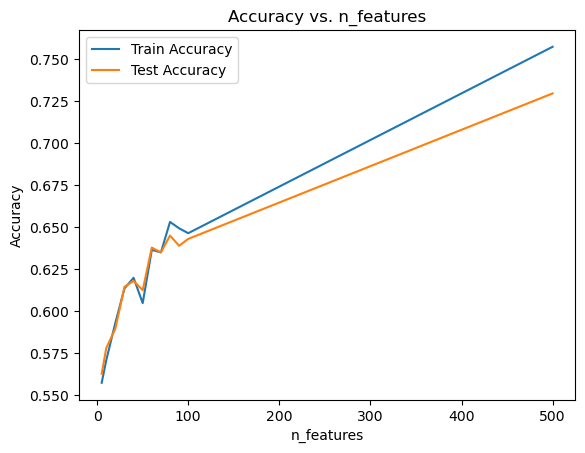

In [214]:
# Columns to apply feature hashing
columns_to_hash = ['from_display_name', 'from_username']

# Initialize lists to store n_features and accuracies
n_features_values = [5,10,20,30,40,50,60,70,80,90,100,500]
train_scores = []
val_scores = []

for n_features in n_features_values:
    # Initialize the FeatureHasher
    hasher = FeatureHasher(n_features=n_features, input_type='string')

    # Apply feature hashing to X_train
    X_train_hashed = hasher.transform(X_train[columns_to_hash].values.astype(str))

    # Train a model on the hashed features
    logit = LogisticRegression()
    logit.fit(X_train_hashed, y_train)

    # Apply feature hashing to X_test
    X_val_hashed = hasher.transform(X_validation[columns_to_hash].values.astype(str))

    # Calculate train accuracy
    train_accuracy = logit.score(X_train_hashed, y_train)
    train_scores.append(train_accuracy)

    # Calculate test accuracy
    val_accuracy = logit.score(X_val_hashed, y_validation)
    val_scores.append(val_accuracy)

# Plot the graph
plt.plot(n_features_values, train_scores, label='Train Accuracy')
plt.plot(n_features_values, val_scores, label='Test Accuracy')
plt.xlabel('n_features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. n_features')
plt.legend()
plt.show()

The accuracy is going up as we increase number of features. However, it leads to overfitting. So we can get the best number of features, where the train and validation accuracies are the closest and doesnt overfit. Looking at the graph, we decide to keep the minimum validation score to be 60%.

In [215]:
# Find the indices where val_scores > 0.60
val_indices = np.where(np.array(val_scores) > 0.60)[0]

# Calculate the absolute difference between train_scores and val_scores
abs_diff = np.abs(np.array(train_scores) - np.array(val_scores))

# Find the index with the minimum absolute difference among the selected indices
valid_indices = val_indices[abs_diff[val_indices].argmin()]

# Get the corresponding best_n_features value
best_n_features = n_features_values[valid_indices]

best_n_features

70

Compute the scores of feature hashing with the best n_feature

In [218]:
# Initialize the FeatureHasher with best n_features
hasher = FeatureHasher(n_features=best_n_features, input_type='string')

# Apply feature hashing to X_train
X_train_hashed = hasher.transform(X_train[columns_to_hash].values.astype(str))

# Train a model on the hashed features
logit = LogisticRegression()
logit.fit(X_train_hashed, y_train)
best_train_accuracy = logit.score(X_train_hashed, y_train)
best_test_accuracy = logit.score(X_test_hashed, y_test)
print('Final Feature Hashing Logistic Regression Train accuracy is {:.2f}%'.format(best_train_accuracy*100))
print('Final Feature Hashing Logistic Regression Test accuracy is {:.2f}%'.format(best_test_accuracy*100))

Final Feature Hashing Logistic Regression Train accuracy is 63.50%
Final Feature Hashing Logistic Regression Test accuracy is 63.16%


Next, convert the result to data frame and check the feature hashed dataframe.

In [221]:
# Create hashed X_train dataframe
X_train_hashed_df = feature_hashed_df(X_train_hashed)
print(f'The shape of feature hashed X_train is {X_train_hashed_df.shape}')
# Check the values
X_train_hashed_df.head()

The shape of feature hashed X_train is (22400, 70)


,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69
0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Apply the transformation to X_test and X_validation sets

In [222]:
# Apply feature hashing to X_test
X_test_hashed = hasher.transform(X_test[columns_to_hash].values.astype(str))
# Apply feature hashing to X_validation
X_val_hashed = hasher.transform(X_validation[columns_to_hash].values.astype(str))
# Create hashed X_train dataframe
X_test_hashed_df = feature_hashed_df(X_test_hashed)
# Create hashed X_train dataframe
X_val_hashed_df = feature_hashed_df(X_val_hashed)

Join the new features to original set and drop the features that are hashed

In [223]:
# Use concat_and_drop function to recreate X_train, X_test, X_validation and X_remainder
X_train = concat_and_drop(X_train, X_train_hashed_df, columns_to_hash)

X_test = concat_and_drop(X_test, X_test_hashed_df, columns_to_hash)

X_validation = concat_and_drop(X_validation, X_val_hashed_df, columns_to_hash)

# View the head of X_train
X_train.head()

The shape of X_train is (22400, 76)
The shape of X_test is (12000, 76)
The shape of X_validation is (5600, 76)


,subject,message,from_host,from_domain,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69
0,Re: Proposal for SAMBA_3_0/README.Coding,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,Others,org,4,93,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,In he ballantine,Does Size Matter?'\n____\n\n60% of WOMEN said ...,Others,net,3,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Why seek? Choose any love pi11 you want!,Content-Type: multipart/alternative;\n\tbounda...,Others,Others,8,338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
3,invitation to fill in the vacant position of a...,Content-Type: text/html;\nContent-Transfer-Enc...,Others,com,11,568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Windows server returning ""non specific error c...","Windows CIFS server (2003) is returning a ""Non...",gmail,com,7,175,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
# Check the shapes 
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')
print(f'The shape of X_validation is {X_validation.shape}')

The shape of X_train is (22400, 76)
The shape of X_test is (12000, 76)
The shape of X_validation is (5600, 76)


<a id = "ohe"></a>
### 3.2. One Hot encode: Host and Domain

Now, we are going to one hot encode email host and domain extension of sender email address.

In [226]:
# Separate the columns to one hot encode
X_train_oneHot = X_train[['from_host', 'from_domain']]
X_train_oneHot.head()

,from_host,from_domain
0,Others,org
1,Others,net
2,Others,Others
3,Others,com
4,gmail,com


Use column transformer to one hot encode two columns together.

In [228]:
# Create the column transformations list + columns to which to apply
col_transforms = [('host_transform', OneHotEncoder(), ['from_host']),
                ('domain_transform', OneHotEncoder(), ['from_domain'])]
# Create the column transformer
col_trans = ColumnTransformer(col_transforms)

# Fit
col_trans.fit(X_train_oneHot)

# Apply the transformations
transformed = col_trans.transform(X_train_oneHot) 

# Put in a DataFrame
transformed_df = pd.DataFrame(transformed.toarray(), columns=col_trans.get_feature_names_out())
transformed_df.head()

,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Join the transformed columns to original dataset and drop the features that are already transformed.

In [229]:
# Concatenate transformed_df to X_train along axis 1 (columns)
X_train = pd.concat([X_train, transformed_df], axis=1)

# Drop the 'from_host' and 'from_domain' columns from X_train
X_train.drop(['from_host', 'from_domain'], axis=1, inplace=True)
X_train.head()

,subject,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk
0,Re: Proposal for SAMBA_3_0/README.Coding,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,4,93,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,In he ballantine,Does Size Matter?'\n____\n\n60% of WOMEN said ...,3,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Why seek? Choose any love pi11 you want!,Content-Type: multipart/alternative;\n\tbounda...,8,338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,invitation to fill in the vacant position of a...,Content-Type: text/html;\nContent-Transfer-Enc...,11,568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,"Windows server returning ""non specific error c...","Windows CIFS server (2003) is returning a ""Non...",7,175,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
Now, apply the transformation on test and validation 

In [230]:
# Separate features for one hot encoding
X_test_oneHot = X_test[['from_host', 'from_domain']]

# Apply the transformations
transformed = col_trans.transform(X_test_oneHot) 

# Put in a DataFrame
transformed_df = pd.DataFrame(transformed.toarray(), columns=col_trans.get_feature_names_out())

# Concatenate transformed_df to X_train along axis 1 (columns)
X_test = pd.concat([X_test, transformed_df], axis=1)

# Drop the 'from_host' and 'from_domain' columns from X_train
X_test.drop(['from_host', 'from_domain'], axis=1, inplace=True)
X_test.head()

,subject,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk
0,Increase Your Odds of Getting a Grant,You registered to receive this and similar off...,7,208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,due to expansion of activities our company is ...,Content-Type: text/html;\nContent-Transfer-Enc...,20,574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Re: gentoo dropping speakup support,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,5,124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Dude check out this sweet site,Content-Type: text/plain; charset=Windows-1252...,6,313,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,svn commit: samba r22383 - in\n\tbranches/SAMB...,Author: metze\nDate: 2007-04-19 17:29:57 +0000...,8,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [231]:
# Separate features for one hot encoding
X_val_oneHot = X_validation[['from_host', 'from_domain']]

# Apply the transformations
transformed = col_trans.transform(X_val_oneHot) 

# Put in a DataFrame
transformed_df = pd.DataFrame(transformed.toarray(), columns=col_trans.get_feature_names_out())

# Concatenate transformed_df to X_train along axis 1 (columns)
X_validation = pd.concat([X_validation, transformed_df], axis=1)

# Drop the 'from_host' and 'from_domain' columns from X_train
X_validation.drop(['from_host', 'from_domain'], axis=1, inplace=True)
X_validation.head()

,subject,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk
0,[Ip-health] Venezuela: Antitrust Authorities S...,Estudio Antequera Parilli & Rodriguez\nVenezue...,11,765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Your removal from the MORNINGGRIND list,"Sun, 24 Jun 2007 00:01:15\n\nYou have been au...",6,262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Job just for you. [letter id: 5525411527],Content-Type: text/html;\nContent-Transfer-Enc...,7,588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"Re: Thank you for your recent application, we ...","Content-Type: text/html;\n\tcharset=""us-ascii""...",19,98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Immense gains in germany.,PCWindows,4,1,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [232]:
# Check the shapes
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')
print(f'The shape of X_validation is {X_validation.shape}')

The shape of X_train is (22400, 87)
The shape of X_test is (12000, 87)
The shape of X_validation is (5600, 87)
